In [151]:
from mp_api.client import MPRester


import pandas as pd
import numpy as np

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
import numpy.matlib as nm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLars, BayesianRidge
from sklearn import model_selection


import scipy



# Introduction

* The dataset containes 10000 different adsorption sites generated from 702 different intermetallic materials. Each site is feauturized by the Miedema, WenAlloys, BandCentre from matminer composition featurizer model and the atomic number(Ni_Z), electronegativity(Ni_X), and coordination number(Ni_CN) of the first 8 nearest neighbors of the adsobate hydrogen atom. 
* After performing clustering analysis, one of the cluster is chosen as the subset dominant by (Pd,Pt,Al,Ti). For detailed rationale, see coding section.
* cross-validation folds are splitted on mpid, i.e. adsorption sites from the same bulk structure would not be used to train each other.
* Full feature set is used for linear fitting (feature drop based on correlation analysis is not performed)
* The target property: Hydrogen atom adsorption energy is modeled

# Coding Section

### Subset selection for linear model

Load the dataset

In [271]:
df = pd.read_csv('h_data_modelinput.csv').drop(columns=['Unnamed: 0']).sort_values(by=['mpid'])
df.index = range(len(df))
print('# of adsorption sites:', len(df))
print('# of features:', df.shape[1]-3)
print("type of intermetallic materials:",len(df['mpid'].unique()))

# of adsorption sites: 10000
# of features: 56
type of intermetallic materials: 702


Generate a column of chemical symbols of each datapoint 
for exploration of elements distribution upon clustering

In [3]:
# create a dictionary for mp-id and the corresponding list of elements of the material 
mp_list = list(df['mpid'].unique())
prop = ['material_id','chemsys']
formu_elem = {}
with MPRester("JcjACBt45HOv4RNHua4YOSrdWEFqoIJw") as mpr:
    docs = mpr.summary.search(material_ids=mp_list,fields=prop)
    formu_elem['mp_id']=[str(getattr(doc, 'material_id')) for doc in docs]
    formu_elem['chemsys']= [getattr(doc,'chemsys').split('-') for doc in docs]
formu_elem = pd.DataFrame.from_dict(formu_elem) 
dic = dict(zip(formu_elem.mp_id, formu_elem.chemsys))

# create a new column of chemical symbols
df['chemsys']=df['mpid'].map(dic)

# reorder the column for later operation
col_old = list(df.keys())
col_new = ['mpid', 'formula','chemsys','energy', 'shift', 'top', 'miller1', 'miller2', 'miller3', 'Miedema_deltaH_inter', 'Miedema_deltaH_amor', 'Miedema_deltaH_ss_min', 'Yang delta', 'Yang omega', 'APE mean', 'Radii local mismatch', 'Radii gamma', 'Configuration entropy', 'Atomic weight mean', 'Total weight', 'Lambda entropy', 'Electronegativity delta', 'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy', 'Mean cohesive energy', 'Interant electrons', 'Interant s electrons', 'Interant p electrons', 'Interant d electrons', 'Interant f electrons', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus local mismatch', 'Shear modulus strength model', 'band center', 'N1_Z', 'N1_X', 'N1_CN', 'N2_Z', 'N2_X', 'N2_CN', 'N3_Z', 'N3_X', 'N3_CN', 'N4_Z', 'N4_X', 'N4_CN', 'N5_Z', 'N5_X', 'N5_CN', 'N6_Z', 'N6_X', 'N6_CN', 'N7_Z', 'N7_X', 'N7_CN', 'N8_Z', 'N8_X', 'N8_CN']
print(set(col_new)==set(col_old))
df=df[col_new]

df.head(5)

Retrieving SummaryDoc documents:   0%|          | 0/702 [00:00<?, ?it/s]

True


,mpid,formula,chemsys,energy,shift,top,miller1,miller2,miller3,Miedema_deltaH_inter,...,N5_CN,N6_Z,N6_X,N6_CN,N7_Z,N7_X,N7_CN,N8_Z,N8_X,N8_CN
0,mp-10010,Al(CoSi)2,"[Al, Co, Si]",-0.413011,0.000000,1.0,1,1,0,-0.371987,...,3.931352,11.231276,0.782030,3.327786,11.231276,0.782030,0.831946,3.289735,0.407421,1.518339
1,mp-10010,Al(CoSi)2,"[Al, Co, Si]",-0.128759,0.046290,1.0,1,1,1,-0.371987,...,0.789922,11.232345,0.782104,2.496077,11.232346,0.782104,3.328102,11.232346,0.782104,3.328102
2,mp-10010,Al(CoSi)2,"[Al, Co, Si]",-0.314956,0.250000,1.0,1,1,1,-0.371987,...,3.328102,5.004016,0.679116,3.931727,4.884237,0.662861,3.488740,11.232346,0.782104,3.328102
3,mp-10010,Al(CoSi)2,"[Al, Co, Si]",-0.326548,0.913035,1.0,2,2,1,-0.371987,...,2.244627,9.600621,0.668488,2.133471,4.734670,0.329673,1.402865,3.232181,0.438653,2.077831
4,mp-10010,Al(CoSi)2,"[Al, Co, Si]",-0.260432,0.913035,1.0,2,2,1,-0.371987,...,3.655748,3.246080,0.402015,2.996382,2.494917,0.338596,1.960292,5.081792,0.353843,1.505716


### Clustering & Visualization

Perform PCA analysis to obtain the PCs for visualiztion

In [4]:
fea = df[list(df.keys())[4:]].to_numpy()     # exclude the first 4 columns that are not numerical features
scaler = preprocessing.StandardScaler()      # standardize the data
fea = scaler.fit_transform(fea)
n_components = fea.shape[-1] 
print("number of components:", n_components)

pca = PCA(n_components)                      # calculate the PCs and the explained variance 
pca.fit(fea)                                                 
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

number of components: 56


**PCA plot (PC2 vs PC1)**

-3.975437594999962 4.901974605000005


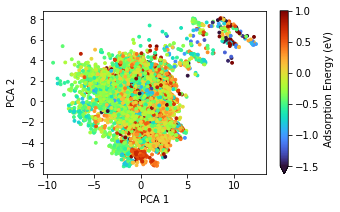

In [5]:
# use the target values as color map
color = df['energy'].to_numpy()
print(color.min(),color.max())

# normalized to focus on the interval of 90% of the target values are populated 
# to increase the color contrast at the most populated value range
plt.figure(figsize=(5,3))
norm = colors.Normalize(vmin=-1.5, vmax=1) 
plt.scatter(pos[:,0],pos[:,1],s=8,c = color,norm=norm, cmap='turbo')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label = 'Adsorption Energy (eV)',extend='min')

plt.show()

**Clustering**

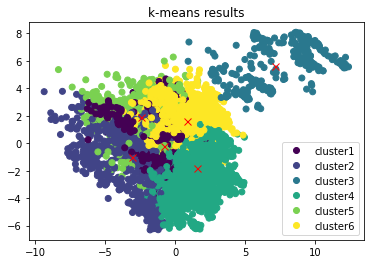

In [6]:
k = 6
plt.figure(figsize = (6,4))
kmeans = KMeans(n_clusters=k, random_state =42).fit(pos) # perform clustering over the PCs
L = kmeans.labels_
label = []
for i in range(k):                                        # generate label for each cluster
    label.append('cluster'+str(i+1))         
cluster_centers = kmeans.cluster_centers_
plt.subplot(1,1,1)
scatter = plt.scatter(pos[:,0],pos[:,1],c = L)
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
plt.legend(scatter.legend_elements()[0],label)
plt.title('k-means results')
plt.show()

**Target map of each cluster**  
According to the plot of the target map for each cluster, the cluster 1 & 5 have a relatively more systematically variation of trend for the target property: the left side have more negative values and the right bottome side have more large positive values.

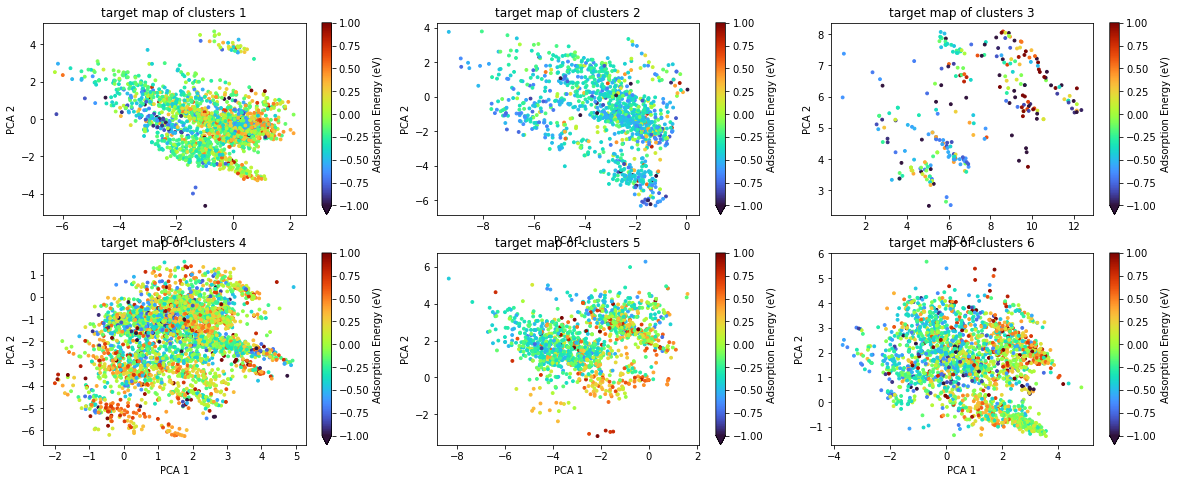

In [7]:
df1=[pd.DataFrame(L),df]
df1=pd.concat(df1,axis=1).dropna()   # concat the clustering label to the original dataframe

k = 6
plt.figure(figsize=(20,12))
for n in range(k):   
    cluster = df1[df1[0]==n]
    idx=np.where(L==n)[0]   # find the index of data that belongs to cluster n
    
    plt.subplot(3,3,n+1)
    color = cluster['energy'].to_numpy()   # generate color map 
    norm = colors.Normalize(vmin=-1, vmax=1)
    plt.scatter(pos[idx,0],pos[idx,1],s=8,c=color,norm=norm, cmap='turbo')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(label = 'Adsorption Energy (eV)',extend='min')
    plt.title('target map of clusters '+str(n+1))    
plt.show()

Element histogram of each cluster 

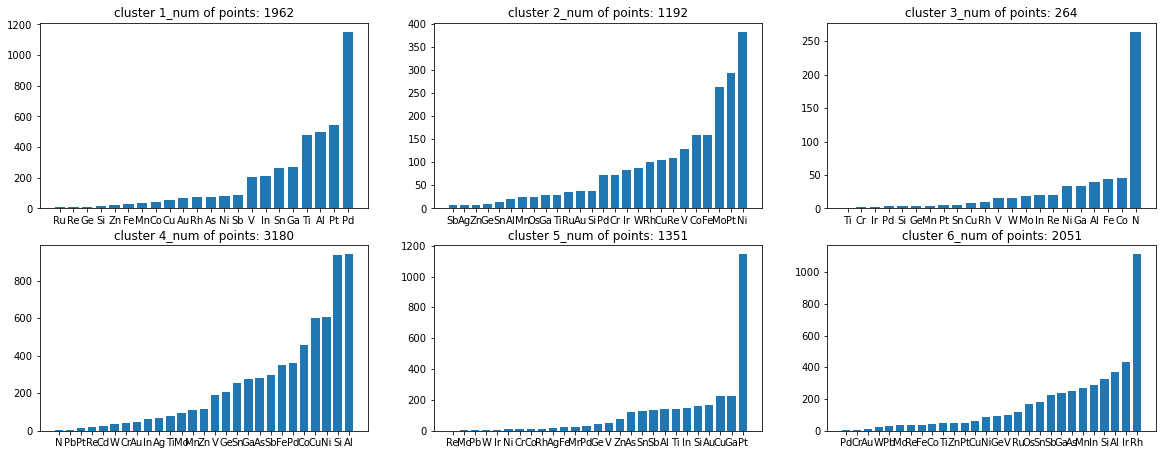

In [8]:
# https://stackoverflow.com/questions/15672178/plot-a-histogram-with-the-x-axis-values-based-on-the-height-of-the-column
plt.figure(figsize = (20,7.5))
for i in range(k):
    plt.subplot(2,3,i+1)
    cluster = df1[df1[0]==i]
    data = cluster.chemsys.sum()
    correlation = [(i, data.count(i)) for i in set(data)]    # generate a list of element and element.count pair 
    correlation.sort(key=lambda x: x[1])
    labels, values = zip(*correlation)
    indexes = np.arange(len(correlation))
    width = 0.75
    title = 'cluster '+str(i+1)+'_num of points: '+str(len(cluster))
    plt.title(label=title)
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels)
plt.show()

Calculate the R^2(simple linear regression) between the PCs and target value of each cluster as a reference info

In [77]:
for n in range(6):
    idx=np.where(L==n)[0]
    X = pos[idx,:]
    
    cluster = df1[df1[0]==n]
    Y = cluster['energy'].to_numpy()
    
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X,Y)
    intercept = LR.intercept_
    coef = LR.coef_
    print('cluster_'+str(n+1),f':R^2={round(LR.score(X,Y),3)}')

cluster_1 :R^2=0.363
cluster_2 :R^2=0.301
cluster_3 :R^2=0.199
cluster_4 :R^2=0.263
cluster_5 :R^2=0.331
cluster_6 :R^2=0.164


### Subset Selection & Rationale  
The datapoint of cluster 1 is selected as the subset to fit to the linear model based on the following considerations:
* the target property have a relatively systematical trend of variation according to visualization
* fair amount of datapoints (3rd largest cluster)
* fairly even distribution of element (better than cluster 1 & 5), therefore the model could be more generative 
* highest R^2 among the cluster, which confirm of observation of rationale 1

In [9]:
df_c1 = df1[df1[0]==0]
df_c1.to_csv('h_data_cluster1.csv')

### Cross Validation Folds spliting  
The cross validation folds are defined according to material id, adsorption site with the same bulk structre(mpid) would not be used train each other.

In [125]:
cv = model_selection.GroupKFold(n_splits=6)
groups=df_c1['mpid']

In [67]:
from sklearn.model_selection import cross_val_score

cross_val_score(LR, X, y, cv=cv.split(df_c1, groups=groups), verbose=4) 

[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s
[CV] END ................................ score: (test=1.000) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([1., 1., 1., 1., 1.])

### Model Fitting

#### Model 1: LASSO

Lasso Regression:  Training R^2=0.379
Lasso Regression:  Training R^2=0.399
Lasso Regression:  Training R^2=0.347
Lasso Regression:  Training R^2=0.33
Lasso Regression:  Training R^2=0.377
Lasso Regression:  Training R^2=0.384


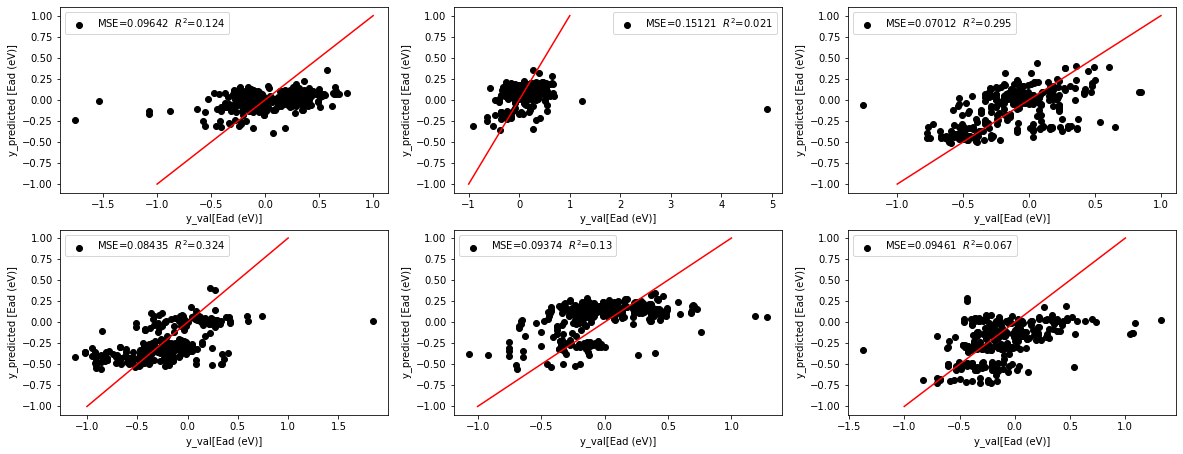

In [182]:
scaler = preprocessing.StandardScaler() 

X = df_c1[list(df_c1.keys())[5:]].to_numpy() 

cluster = df1[df1[0]==n]
y = cluster['energy'].to_numpy()
y_hat_tot=[]
y_val_tot=[]

plt.figure(figsize=(20,7.5))

i=1
for train, val in cv.split(df_c1, groups=groups):
    # standardize the data
    X_train, X_val = scaler.fit_transform(X[train]), scaler.transform(X[val])
    y_train, y_val = y[train], y[val]
    
    LS = Lasso(alpha=0.0001, fit_intercept=True)
    LS.fit(X_train, y_train)
    
    y_hat = LS.predict(X_val)
    y_val_tot.append(y_val)
    y_hat_tot.append(y_hat)
    
    mse = mean_squared_error(y_val, y_hat)
    print('Lasso Regression: ',f'Training R^2={round(LS.score(X_train,y_train),3)}')
    
    # parity plot
    plt.subplot(2,3,i)
    plt.plot([-1,1],[-1,1], c='r') # plot a line of slope=1 for reference
    # label each plot 
    plt.scatter(y_val, y_hat, c='k', label=f'MSE={round(mse,5)}'+'  $R^{2}$='+ str(round(r2_score(y_val, y_hat),3))) 
    plt.legend()
    plt.xlabel('y_val[Ead (eV)]')
    plt.ylabel('y_predicted [Ead (eV)]')
    i+=1
    
plt.show()

Plot the predictions vs actual of the whole dataset 

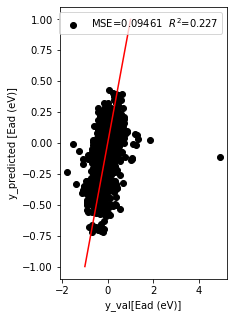

In [193]:
plt.figure(figsize=(3,5))

y_hat = np.concatenate(y_hat_tot)
y_val = np.concatenate(y_val_tot)
plt.plot([-1,1],[-1,1], c='r') # plot a line of slope=1 for reference
# label each plot 
plt.scatter(y_val, y_hat, c='k', label=f'MSE={round(mse,5)}'+'  $R^{2}$='+ str(round(r2_score(y_val, y_hat),3))) 
plt.legend()
plt.xlabel('y_val[Ead (eV)]')
plt.ylabel('y_predicted [Ead (eV)]')
plt.show()

**Model 2: Ridge**

Lasso Regression:  Training R^2=0.342
Lasso Regression:  Training R^2=0.362
Lasso Regression:  Training R^2=0.314
Lasso Regression:  Training R^2=0.298
Lasso Regression:  Training R^2=0.349
Lasso Regression:  Training R^2=0.352


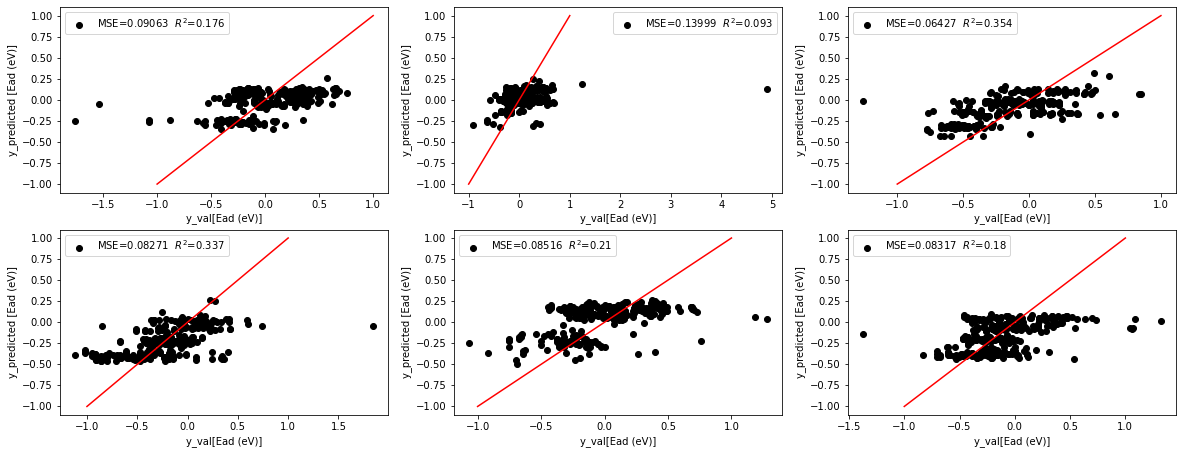

In [273]:
y_hat_tot=[]
y_val_tot=[]

plt.figure(figsize=(20,7.5))

i=1
for train, val in cv.split(df_c1, groups=groups):
    # standardize the data
    X_train, X_val = scaler.fit_transform(X[train]), scaler.transform(X[val])
    y_train, y_val = y[train], y[val]
    
    RR = Ridge(alpha=750,fit_intercept=True)
    RR.fit(X_train, y_train)
    
    y_hat = RR.predict(X_val)
    y_val_tot.append(y_val)
    y_hat_tot.append(y_hat)
    
    mse = mean_squared_error(y_val, y_hat)
    print('Lasso Regression: ',f'Training R^2={round(RR.score(X_train,y_train),3)}')
    
    # parity plot
    plt.subplot(2,3,i)
    plt.plot([-1,1],[-1,1], c='r') # plot a line of slope=1 for reference
    # label each plot 
    plt.scatter(y_val, y_hat, c='k', label=f'MSE={round(mse,5)}'+'  $R^{2}$='+ str(round(r2_score(y_val, y_hat),3))) 
    plt.legend()
    plt.xlabel('y_val[Ead (eV)]')
    plt.ylabel('y_predicted [Ead (eV)]')
    i+=1
    
plt.show()

Plot the predictions vs actual of the whole dataset 

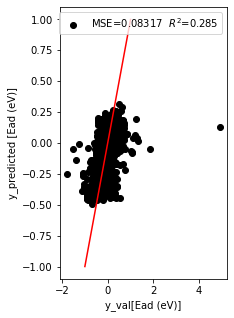

In [219]:
plt.figure(figsize=(3,5))

y_hat = np.concatenate(y_hat_tot)
y_val = np.concatenate(y_val_tot)
plt.plot([-1,1],[-1,1], c='r') # plot a line of slope=1 for reference
# label each plot 
plt.scatter(y_val, y_hat, c='k', label=f'MSE={round(mse,5)}'+'  $R^{2}$='+ str(round(r2_score(y_val, y_hat),3))) 
plt.legend()
plt.xlabel('y_val[Ead (eV)]')
plt.ylabel('y_predicted [Ead (eV)]')
plt.show()

### LASSO coefficients investigation

In [227]:
# train the model with full subset, with the selected parameters
LS = Lasso(alpha=0.0001, fit_intercept=True)
LS.fit(X, y)
coeff = LS.coef_
# find the "uninformative" features: coeff == 0
fea_lst = np.array(df_c1.keys())[5:]
idx = np.where(coeff == 0)[0]

# print the "uninformative" features indicated by LASSO
fea_lst[idx]

array(['Miedema_deltaH_amor', 'Yang delta', 'Radii gamma',
       'Configuration entropy', 'Electronegativity delta',
       'Interant f electrons', 'Shear modulus delta',
       'Shear modulus strength model', 'N5_X'], dtype=object)

In [245]:
# print the top 10 features valued by LASSO
idx1 = np.where(coeff >= 1.5e-2)[0]
#print(len(idx1))
fea_lst[idx1]

array(['shift', 'miller2', 'Miedema_deltaH_inter',
       'Miedema_deltaH_ss_min', 'Yang omega', 'VEC mean',
       'Interant s electrons', 'Interant p electrons', 'N2_X', 'N7_X'],
      dtype=object)

# Summary

The features devalued by the LASSO model are: 'Miedema_deltaH_amor', 'Yang delta', 'Radii gamma', 'Configuration entropy', 'Electronegativity delta', 'Interant f electrons', 'Shear modulus delta','Shear modulus strength model', 'N5_X'

The top 10 features valued by the LASSO model are: 'shift', 'miller2', 'Miedema_deltaH_inter','Miedema_deltaH_ss_min', 'Yang omega', 'VEC mean','Interant s electrons', 'Interant p electrons', 'N2_X', 'N7_X'

Some of the devalued features make physical sense to me. For instance, since I am predicting the hydrogen adsorption energy for a surface site, the 'Shear modulus delta' & 'Shear modulus strength model' seems irrelavant. 'shift value' is also important upon defining the adsorption surface from the bulk.

However, most of the valued/devalued features does not make physical sense to me. N5_X (electronegativity of the 5th nearest neighbor) would obviously be more valuable than the info of 6th, 7th, any further nearest neigbor atoms, however, N7_X is somehow choosed as one of the most important features. Also, the features of the nearest neighor (N1_Z/N1_X/N1_CN) are expected to have the most priority instead that of N7.(might due to correlation) The LASSO model also failed to capture the ‘interant d electrons’ as a very crucial feature, while indeed adsorption performance would depend on the d-band of the material a lot. 

The potential reasons could be the dependence of the target property on the expected top features are not linear, thus are not priorized. The linear model itself also have limited predictative power

**Two-panel plot**
no obvious different is observed, indicating poor linear relationship overall

In [249]:
fea_lst[np.where(coeff == coeff.max())[0]][0]

'Miedema_deltaH_inter'

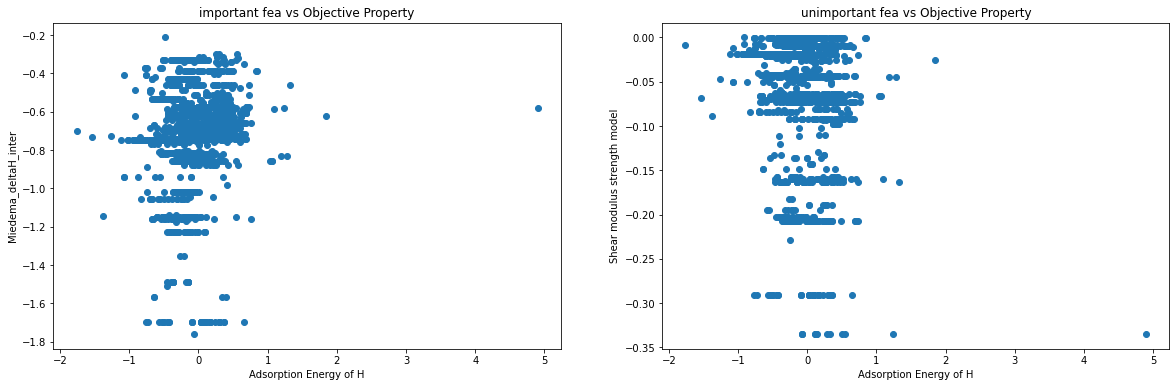

In [272]:
plt.figure(figsize=(20,6))

top_fea = fea_lst[np.where(coeff == coeff.max())[0]][0]
down_fea = 'Shear modulus strength model'

y1=df_c1[top_fea]
y2=df_c1[down_fea]
x1=df_c1['energy']

plt.subplot(1,2,1)
plt.scatter(x1,y1) 
plt.title('important fea vs Objective Property')
plt.xlabel('Adsorption Energy of H')
plt.ylabel(top_fea)


plt.subplot(1,2,2)
plt.scatter(x1,y2) 
plt.title('unimportant fea vs Objective Property')
plt.xlabel('Adsorption Energy of H')
plt.ylabel(down_fea)
plt.show()

**Proposing 10 new materials**

Since my datapoints are generated from the actual detailed structual information, therefore I simply pull 10 data point from other clusters(with different mpid/bulk structure) 

The predictions are probably very bad, as the model perform poorly on the subset itself (even upon training), and the new materials have different set of dominat elements

In [295]:
cluster2 = df1[df1[0]==2]
for i in range(len(cluster2)):
    if cluster2.iloc[i].mpid in list(cluster.mpid.unique()):
        cluster2.drop(index=i,inplace=True)
        
prop = cluster2.sample(10, random_state=40)
X_10 = prop[list(df_c1.keys())[5:]].to_numpy() 
y_10 = prop['energy'].to_numpy() 

In [303]:
# LASSO
LS = Lasso(alpha=0.0001, fit_intercept=True)
LS.fit(X, y)
y_hat = LS.predict(X_10)
print(mean_squared_error(y_10, y_hat))

2.011625735129466


In [304]:
# Ridge
RR = Ridge(alpha=750,fit_intercept=True)
RR.fit(X_10, y_10)
y_hat = RR.predict(X_10)
print(mean_squared_error(y_10, y_hat))

0.3949170351152452
